In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from statsforecast import StatsForecast


In [ ]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)

store_nbr=list(df.store_nbr.unique())[0]
df_store_nbr=df[df['store_nbr']==store_nbr]
family=list(df_store_nbr.family.unique())[0]
df_store_nbr_family=df_store_nbr[df_store_nbr['family']==family]
df_store_nbr_family=df_store_nbr_family.set_index('date')
#msno.matrix(df_store_nbr_family[['sales']], freq="M")


# make stationary
ts = df_store_nbr_family['sales']
# Remove trend
ts_diff1 = ts.diff(1)
# Remove weekly seasonality (lag = 7)
ts_diff1_weekly = ts_diff1.diff(7)
# Remove yearly seasonality (lag = 365)
ts_stationary = ts_diff1_weekly.diff(365)
# Drop missing values 
ts_stationary = ts_stationary.dropna()

### Extra functions

In [9]:
import warnings

import numpy as np


def calc_norm_sd(x, original):
    if (len(x) <= 2) and np.all(x == 0):
        warnings.warn(
            "Array should not be all zeroes or should atleast more than 1 datapoint. COV will be NaN"
        )
        cov = np.nan
    else:
        cov = np.std(x) / np.mean(original)
    return cov


def calc_cov(x):
    if (len(x) <= 2) and np.all(x == 0):
        warnings.warn(
            "Array should not be all zeroes or should atleast more than 1 datapoint. COV will be NaN"
        )
        cov = np.nan
    else:
        cov = np.std(x) / np.mean(x)
    return cov


"""Entropy functions"""
# Borrowed from https://github.com/raphaelvallat/antropy/blob/master/antropy/entropy.py

from builtins import range

import numpy as np
import pandas as pd
from numba import njit
from scipy.signal import periodogram




@np.vectorize
def _xlog2x(x):
    """Returns x log2 x if x is positive, 0 if x == 0, and np.nan
    otherwise. This handles the case when the power spectrum density
    takes any zero value.
    """
    return 0.0 if x == 0 else x * np.log2(x)


def spectral_entropy(
    x, sampling_frequency=1, normalize=True, axis=-1, transform_stationary=False
):
    """Spectral Entropy.
    Parameters
    ----------
    x : list or np.array
        1D or N-D data.
    sampling_frequency : float
        Sampling frequency for the FFT, in Hz.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.
    axis : int
        The axis along which the entropy is calculated. Default is -1 (last).
    transform_stationary : bool
        Flag to decide if we should make the series stationary before calculating spectral entropy. Default is False.
    Returns
    -------
    se : float
        Spectral Entropy
    Notes
    -----
    Spectral Entropy is defined to be the Shannon entropy of the power
    spectral density (PSD) of the data:
    .. math:: H(x, sf) =  -\\sum_{f=0}^{f_s/2} P(f) \\log_2[P(f)]
    Where :math:`P` is the normalised PSD, and :math:`f_s` is the sampling
    frequency.
    """
    x = np.asarray(x)
    # Compute and normalize power spectrum
    _, psd = periodogram(x, sampling_frequency, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -_xlog2x(psd_norm).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se


@njit
def _rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


# @njit
@njit
def apply_along_axis_0(func1d, arr):
    """Like calling func1d(arr, axis=0)"""
    if arr.size == 0:
        raise RuntimeError("Must have arr.size > 0")
    ndim = arr.ndim
    if ndim == 0:
        raise RuntimeError("Must have ndim > 0")
    elif 1 == ndim:
        return func1d(arr)
    else:
        result_shape = arr.shape[1:]
        out = np.empty(result_shape, arr.dtype)
        _apply_along_axis_0(func1d, arr, out)
        return out


@njit
def _apply_along_axis_0(func1d, arr, out):
    """Like calling func1d(arr, axis=0, out=out). Require arr to be 2d or bigger."""
    ndim = arr.ndim
    if ndim < 2:
        raise RuntimeError("_apply_along_axis_0 requires 2d array or bigger")
    elif ndim == 2:  # 2-dimensional case
        for i in range(len(out)):
            out[i] = func1d(arr[:, i])
    else:  # higher dimensional case
        for i, out_slice in enumerate(out):
            _apply_along_axis_0(func1d, arr[:, i], out_slice)


@njit
def nb_mean_axis_0(arr):
    return apply_along_axis_0(np.mean, arr)


@njit
def nb_std_axis_0(arr):
    return apply_along_axis_0(np.std, arr)


@njit
def nb_amax_axis_0(arr):
    return apply_along_axis_0(np.amax, arr)


def _into_subchunks(x, subchunk_length, every_n=1):
    """
    Split the time series x into subwindows of length "subchunk_length", starting every "every_n".

    For example, the input data if [0, 1, 2, 3, 4, 5, 6] will be turned into a matrix

        0  2  4
        1  3  5
        2  4  6

    with the settings subchunk_length = 3 and every_n = 2
    """
    len_x = len(x)

    assert subchunk_length > 1
    assert every_n > 0

    # how often can we shift a window of size subchunk_length over the input?
    num_shifts = (len_x - subchunk_length) // every_n + 1
    shift_starts = every_n * np.arange(num_shifts)
    indices = np.arange(subchunk_length)

    indexer = np.expand_dims(indices, axis=0) + np.expand_dims(shift_starts, axis=1)
    return x[indexer]


# @njit
def sample_entropy(x, transform_stationary=False):
    """
    Calculate and return sample entropy of x.

    .. rubric:: References

    |  [1] http://en.wikipedia.org/wiki/Sample_Entropy
    |  [2] https://www.ncbi.nlm.nih.gov/pubmed/10843903?dopt=Abstract

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray

    :return: the value of this feature
    :return type: float
    """
    # x = np.array(x)

    # if one of the values is NaN, we can not compute anything meaningful
    if np.isnan(x).any():
        return np.nan

    m = 2  # common value for m, according to wikipedia...
    tolerance = 0.2 * np.std(
        x
    )  # 0.2 is a common value for r, according to wikipedia...
    
    # Split time series and save all templates of length m
    # Basically we turn [1, 2, 3, 4] into [1, 2], [2, 3], [3, 4]
    xm = _into_subchunks(x, m)

    # Now calculate the maximum distance between each of those pairs
    #   np.abs(xmi - xm).max(axis=1)
    # and check how many are below the tolerance.
    # For speed reasons, we are not doing this in a nested for loop,
    # but with numpy magic.
    # Example:
    # if x = [1, 2, 3]
    # then xm = [[1, 2], [2, 3]]
    # so we will substract xm from [1, 2] => [[0, 0], [-1, -1]]
    # and from [2, 3] => [[1, 1], [0, 0]]
    # taking the abs and max gives us:
    # [0, 1] and [1, 0]
    # as the diagonal elements are always 0, we substract 1.
    B = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= tolerance) - 1 for xmi in xm])

    # Similar for computing A
    xmp1 = _into_subchunks(x, m + 1)
    A = np.sum(
        [np.sum(np.abs(xmi - xmp1).max(axis=1) <= tolerance) - 1 for xmi in xmp1]
    )

    # Return SampEn
    return -np.log(A / B)


@njit
def _phi(x, m, r):
    N = x.shape[0]
    x_re = _rolling(x, m)
    diff = np.abs(x_re.copy().reshape(-1, 1, m) - x_re.copy().reshape(1, -1, m))
    _max = nb_amax_axis_0(np.transpose(diff, (2, 0, 1)))
    _max_mask = _max <= r
    C = np.sum(_max_mask, axis=0) / (N - m + 1)
    return np.sum(np.log(C)) / (N - m + 1.0)


def approximate_entropy(x, m, r, transform_stationary=False):
    """
    Implements a vectorized Approximate entropy algorithm.

        https://en.wikipedia.org/wiki/Approximate_entropy

    For short time-series this method is highly dependent on the parameters,
    but should be stable for N > 2000, see:

        Yentes et al. (2012) -
        *The Appropriate Use of Approximate Entropy and Sample Entropy with Short Data Sets*


    Other shortcomings and alternatives discussed in:

        Richman & Moorman (2000) -
        *Physiological time-series analysis using approximate entropy and sample entropy*

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :param m: Length of compared run of data
    :type m: int
    :param r: Filtering level, must be positive
    :type r: float

    :return: Approximate entropy
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    
    N = x.size
    r *= np.std(x)
    if r < 0:
        raise ValueError("Parameter r must be positive.")
    if N <= m + 1:
        return 0
    return np.abs(_phi(x, m, r) - _phi(x, m + 1, r))


# ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
# a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
# rand_small = np.random.randint(0, 100, size=36)
# rand_big = np.random.randint(0, 100, size=136)
# approximate_entropy(ss.value.values, 2, r=0.2)
# import os
# # os.chdir(r"..")
# t = np.load(r"t.sav.npy")
# sample_entropy(t[:50])




import random
import warnings
import pandas as pd
import numpy as np
#from darts import TimeSeries
from statsforecast.models import *
from statsforecast.core import StatsForecast




def sse(y_true: np.ndarray, y_pred: np.ndarray):
    y_true, y_pred = _remove_nan_union(y_true, y_pred)
    return np.sum((y_true - y_pred) ** 2)


def block_shuffle(x, num_blocks):
    sh_array = np.array_split(x, num_blocks)
    random.shuffle(sh_array)
    return np.concatenate(sh_array)

def _remove_nan_union(y_true: np.ndarray, y_pred: np.ndarray):
    """Remove NaN values from both y_true and y_pred arrays to ensure they are aligned."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]


def expand_to_df(x, start_date='2000-01-01', freq='30min', unique_id='default_id'):
    #x.rename(columns = {'energy_consumption':target_col}, inplace = True)
    data_arrays = np.array(x).T
    dates = pd.date_range(start=start_date, periods=data_arrays.shape[0], freq=freq)
    df = pd.DataFrame(data_arrays, columns=['y','shuffled_y'])
    df['unique_id'] = unique_id  # Add a column with the unique identifier
    df['ds'] = dates  # Add the datetime as a regular column named 'ds'
    return df

def nixtla_backtest(x, model, block_size, backtesting_start, n_folds, freq):
    temp_array = block_shuffle(x, num_blocks = len(x) // block_size )
    x = np.vstack([x, temp_array])

    # Define the output dictionary for SSE values
    sse_results = {}
    temp = expand_to_df(x, freq = freq)

    # Assuming cross_val_cols are columns to be validated
    cross_val_cols = ['y', 'shuffled_y']
    sf = StatsForecast( 
            models = [model], 
            freq = freq )
    
    for col_name in cross_val_cols:
        
        history = int(len(temp) * backtesting_start)
        #print(history)
        crossvalidation_df = sf.cross_validation(
                    df = temp,
                    h = history // n_folds,
                    step_size = history // n_folds,
                    n_windows = n_folds,
                    target_col = col_name )
        #print(crossvalidation_df.head())
        #print(col_name)
        sse_results[f'sse_{col_name}'] = sse(crossvalidation_df[col_name], crossvalidation_df[model.__class__.__name__])
        #print(sse_results)
    return sse_results

def _remove_nan_union(y_true: np.ndarray, y_pred: np.ndarray):
    """Remove NaN values from both y_true and y_pred arrays to ensure they are aligned."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]
   
def sse(y_true: np.ndarray, y_pred: np.ndarray):
    y_true, y_pred = _remove_nan_union(y_true, y_pred)
    return np.sum((y_true - y_pred) ** 2)   

def kaboudan_metric(x, model, block_size , backtesting_start , n_folds , freq ):
    scores = nixtla_backtest(x, model, block_size, backtesting_start, n_folds, freq)
    return 1 - (scores['sse_y'] / scores['sse_shuffled_y'])

def modified_kaboudan_metric(x, model, block_size , backtesting_start , n_folds , freq ):
    scores = nixtla_backtest(x, model, block_size, backtesting_start, n_folds, freq)
    return np.clip(1 - np.sqrt(scores['sse_y'] / scores['sse_shuffled_y']), 0, None)

# def _backtest(model, x, backtesting_start, n_folds):
#     history_len = int(len(x) * backtesting_start)
#     train_x = x[:history_len]
#     test_x = x[history_len:]
#     blocks = np.array_split(test_x, n_folds)
#     metric_l = []
#     for i, block in enumerate(blocks):
#         x_ = TimeSeries.from_values(train_x)
#         with warnings.catch_warnings():
#             warnings.filterwarnings("ignore", category=FutureWarning)
#             model.fit(x_)
#         y_pred = model.predict(len(block))
#         metric_l.append(sse(block, np.squeeze(y_pred.data_array().values)))
#         if i < len(blocks) - 1:
#             train_x = np.concatenate([train_x, block])
#     return np.mean(metric_l) if len(metric_l) > 1 else metric_l[0]


# def kaboudan_metric(x, model, block_size=5, backtesting_start=0.5, n_folds=1):
#     sse_before = _backtest(model, x, backtesting_start, n_folds)
#     x_shuffled = block_shuffle(x, num_blocks=len(x) // block_size)
#     sse_after = _backtest(model, x_shuffled, backtesting_start, n_folds)
#     return 1 - (sse_before / sse_after)



# def modified_kaboudan_metric(x, model, block_size=5, backtesting_start=0.5, n_folds=1):
#     sse_before = _backtest(model, x, backtesting_start, n_folds)
#     x_shuffled = block_shuffle(x, num_blocks=len(x) // block_size)
#     sse_after = _backtest(model, x_shuffled, backtesting_start, n_folds)
#     return np.clip(1 - np.sqrt(sse_before / sse_after), 0, None)

#### Coefficient of variation
- High is good

In [11]:
cv = calc_cov(ts.values)
cv_norm = calc_norm_sd(ts_stationary.values, ts.values)
print(cv_norm)

2.2170463436158445


#### Residual variability
- High is good


In [12]:
residual_variability = np.std(ts_stationary.values) / np.mean(ts.values)
print(residual_variability)

2.2170463436158445


#### Spectral entropy
- High is good

In [15]:
se = spectral_entropy(
    ts_stationary.values,
    sampling_frequency=1,
    normalize=True
)
print(se)

0.8281120507051998


#### Kaboudan metric
 - Low is good

In [16]:
from statsforecast.models import SeasonalNaive

kab = kaboudan_metric(
    x=ts.values,
    model=SeasonalNaive(season_length=7),
    block_size=7,
    backtesting_start=0.5,
    n_folds=3,
    freq='D'
)

kab_mod = modified_kaboudan_metric(
    x=ts.values,
    model=SeasonalNaive(season_length=7),
    block_size=7,
    backtesting_start=0.5,
    n_folds=3,
    freq='D'
)

print(kab,kab_mod)

-0.0062180974477958895 0.14828908582031308


In [17]:
forecastability_df = pd.DataFrame([{
    'CV': cv,
    'Residual_Variability': residual_variability,
    'Spectral_Entropy': se,
    'Kaboudan': kab,
    'Modified_Kaboudan': kab_mod
}])

forecastability_df

,CV,Residual_Variability,Spectral_Entropy,Kaboudan,Modified_Kaboudan
0,0.848547,2.217046,0.828112,-0.006218,0.148289


In [18]:
def compute_forecastability(ts, ts_stationary, model):
    return {
        'CV': calc_cov(ts.values),
        'Residual_Variability': np.std(ts_stationary.values) / np.mean(ts.values),
        'Spectral_Entropy': spectral_entropy(ts_stationary.values),
        'Kaboudan': kaboudan_metric(
            ts.values, model,
            block_size=7,
            backtesting_start=0.5,
            n_folds=3,
            freq='D'
        )
    }

In [49]:
rows = []

for store_nbr in df.store_nbr.unique():
    df_s = df[df.store_nbr == store_nbr]
    for family in df_s.family.unique():
        df_sf = df_s[df_s.family == family].set_index('date')
        ts = df_sf['sales']

        # Make stationary (same as before)
        ts_stationary = (
            ts.diff(1)
              .diff(7)
              .diff(365)
              .dropna()
        )

        metrics = compute_forecastability(
            ts,
            ts_stationary,
            SeasonalNaive(season_length=7)
        )

        metrics['store_nbr'] = store_nbr
        metrics['family'] = family
        rows.append(metrics)

forecastability_all = pd.DataFrame(rows)

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/1201448461.py:24: RuntimeWarning: invalid value encountered in scalar divide
  cov = np.std(x) / np.mean(x)
/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/3265151091.py:4: RuntimeWarning: invalid value encountered in scalar divide
  'Residual_Variability': np.std(ts_stationary.values) / np.mean(ts.values),
/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/1201448461.py:82: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/1201448461.py:366: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (scores['sse_y'] / scores['sse_shuffled_y'])
/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/1201448461.py:24: RuntimeWarning: invalid value encountered in scalar divide
  cov = np.std(x) / np.mean(x)
/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/

In [50]:
family_order = (
    forecastability_all
    .groupby('family')['Spectral_Entropy']
    .median()
    .sort_values()
    .index
)

forecastability_all['family'] = pd.Categorical(
    forecastability_all['family'],
    categories=family_order,
    ordered=True
)

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_forecastability_heatmap(
    df,
    metric,
    vmin=None,
    vmax=None,
    cmap='viridis'
):
    pivot = df.pivot_table(
        index='family',
        columns='store_nbr',
        values=metric,
        aggfunc='mean'  # safe default
    )

    plt.figure(figsize=(12, max(6, 0.4 * pivot.shape[0])))

    sns.heatmap(
        pivot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': metric},
        linewidths=0.3,
        linecolor='gray'
    )

    plt.title(f'{metric} Heatmap (Store × Family)')
    plt.xlabel('Store')
    plt.ylabel('Family')
    plt.tight_layout()
    plt.show()

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/3521719419.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


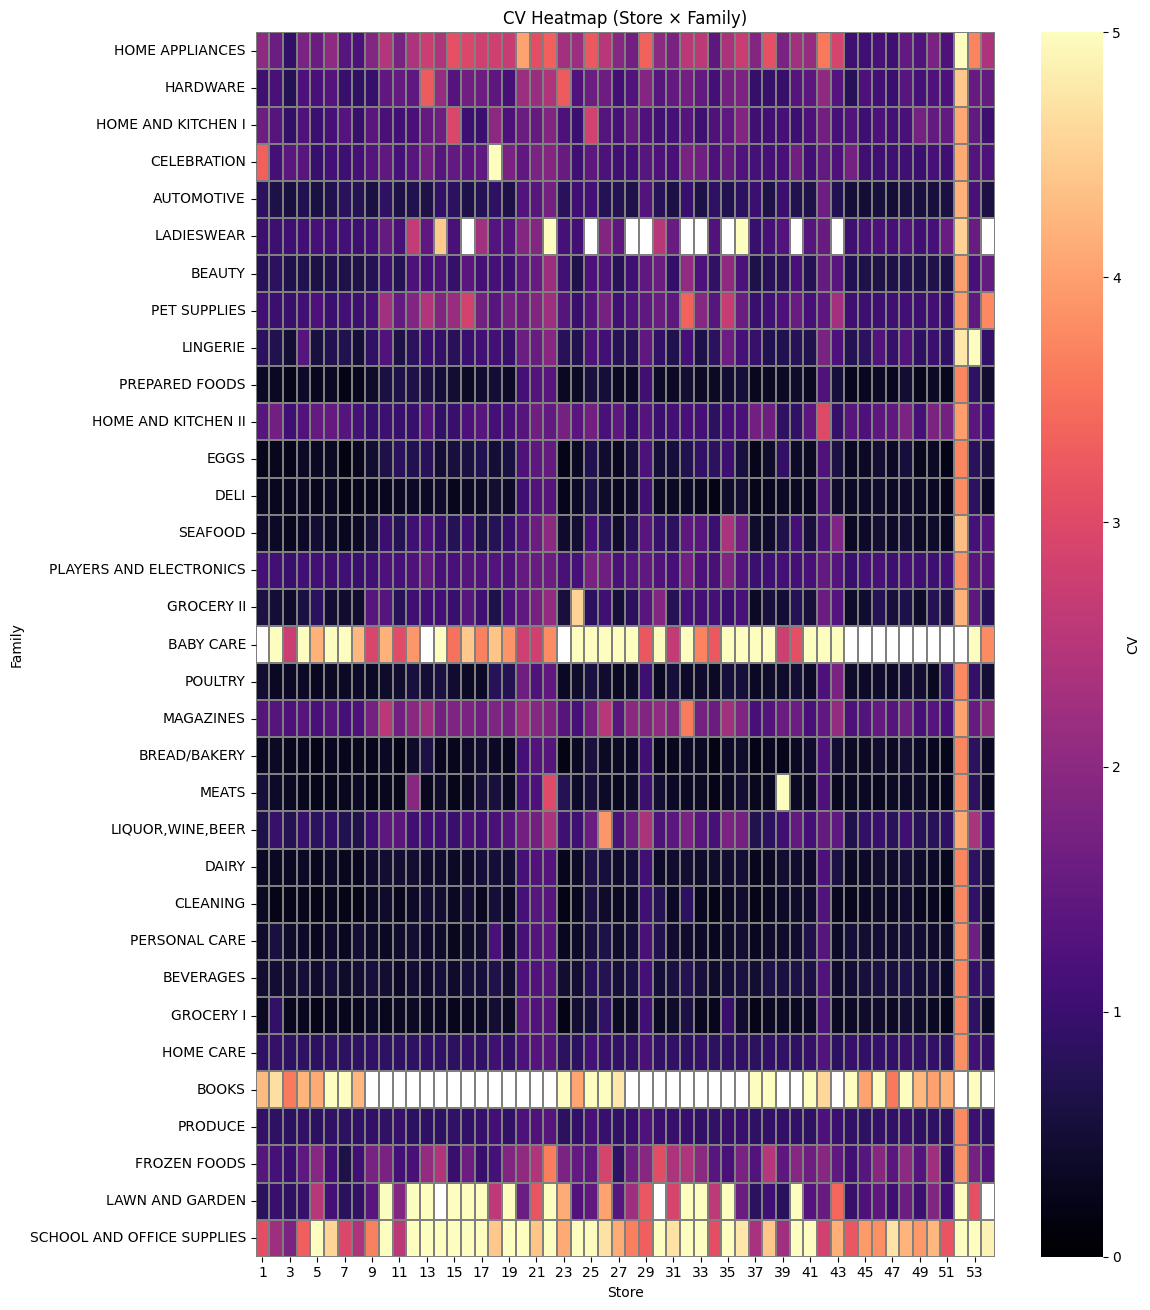

In [52]:
plot_forecastability_heatmap(
    forecastability_all,
    metric='CV',
    vmin=0,
    vmax=5,
    cmap='magma'
)

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/3521719419.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


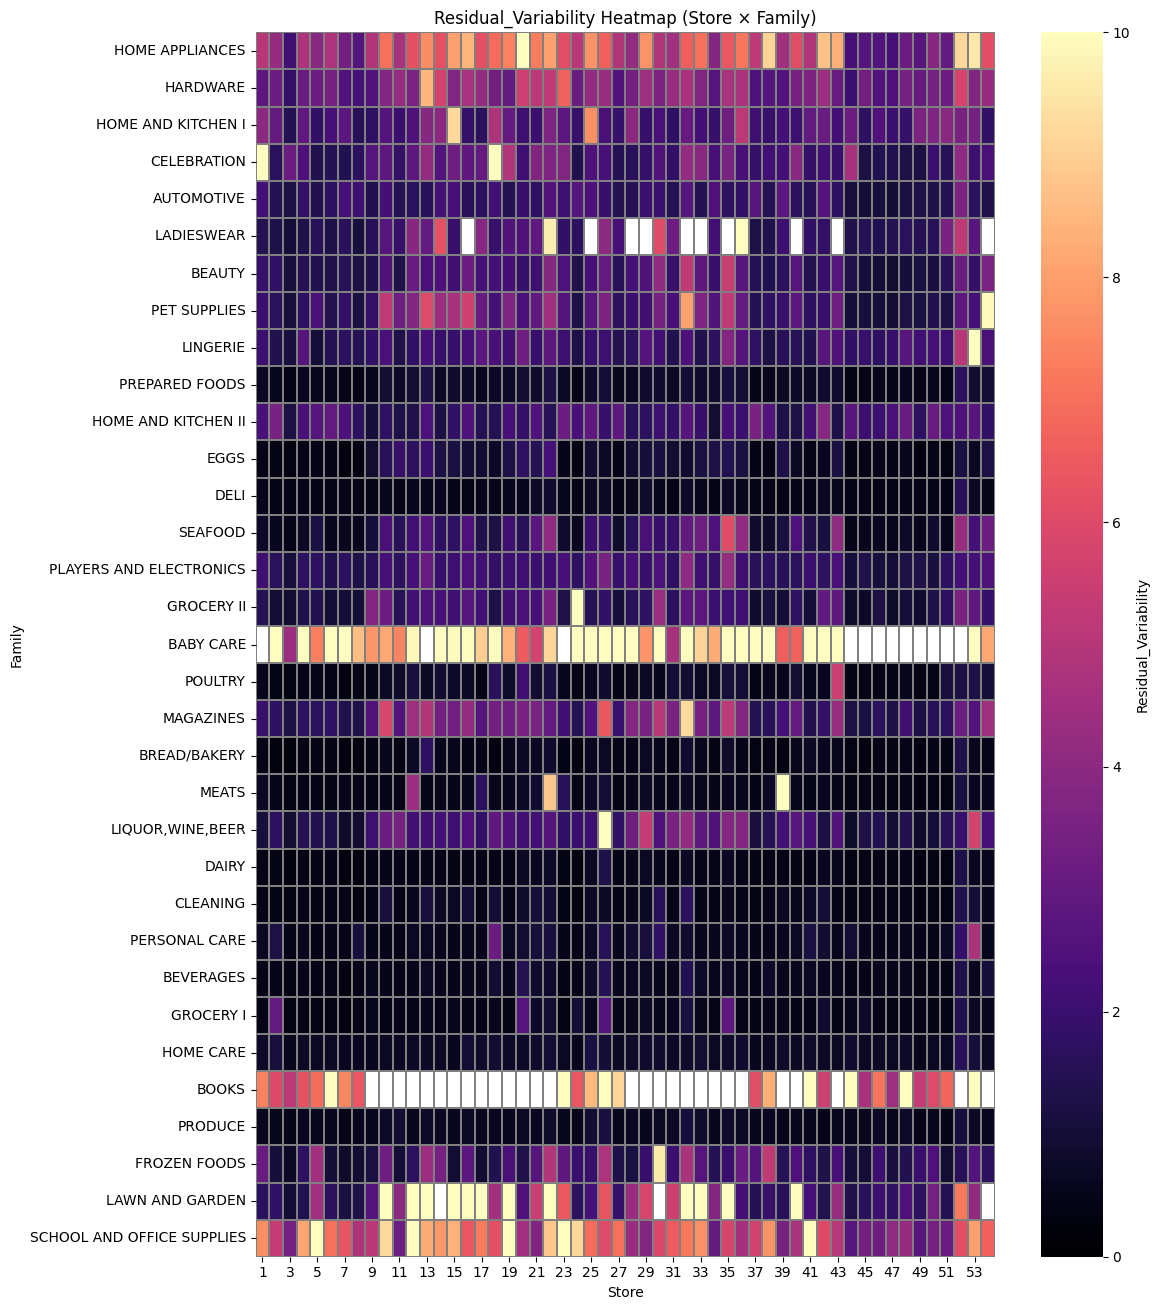

In [53]:
plot_forecastability_heatmap(
    forecastability_all,
    metric='Residual_Variability',
    vmin=0,
    vmax=10,
    cmap='magma'
)

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/3521719419.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


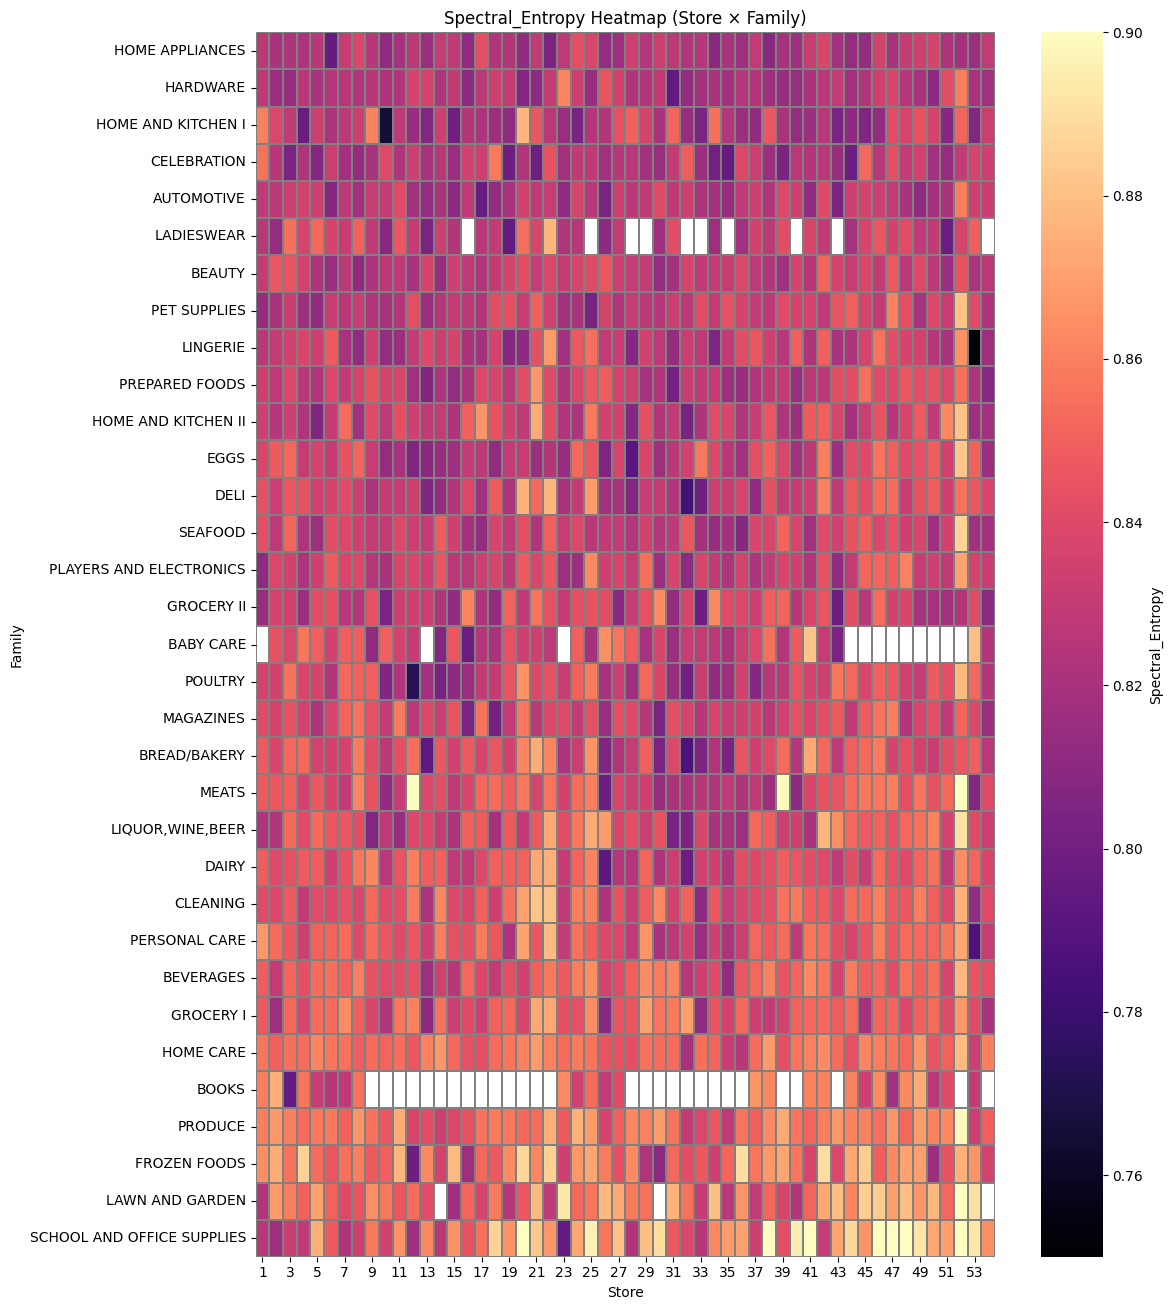

In [57]:
plot_forecastability_heatmap(
    forecastability_all,
    metric='Spectral_Entropy',
    vmin=0.75,
    vmax=0.9,
    cmap='magma'
)

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_33603/3521719419.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


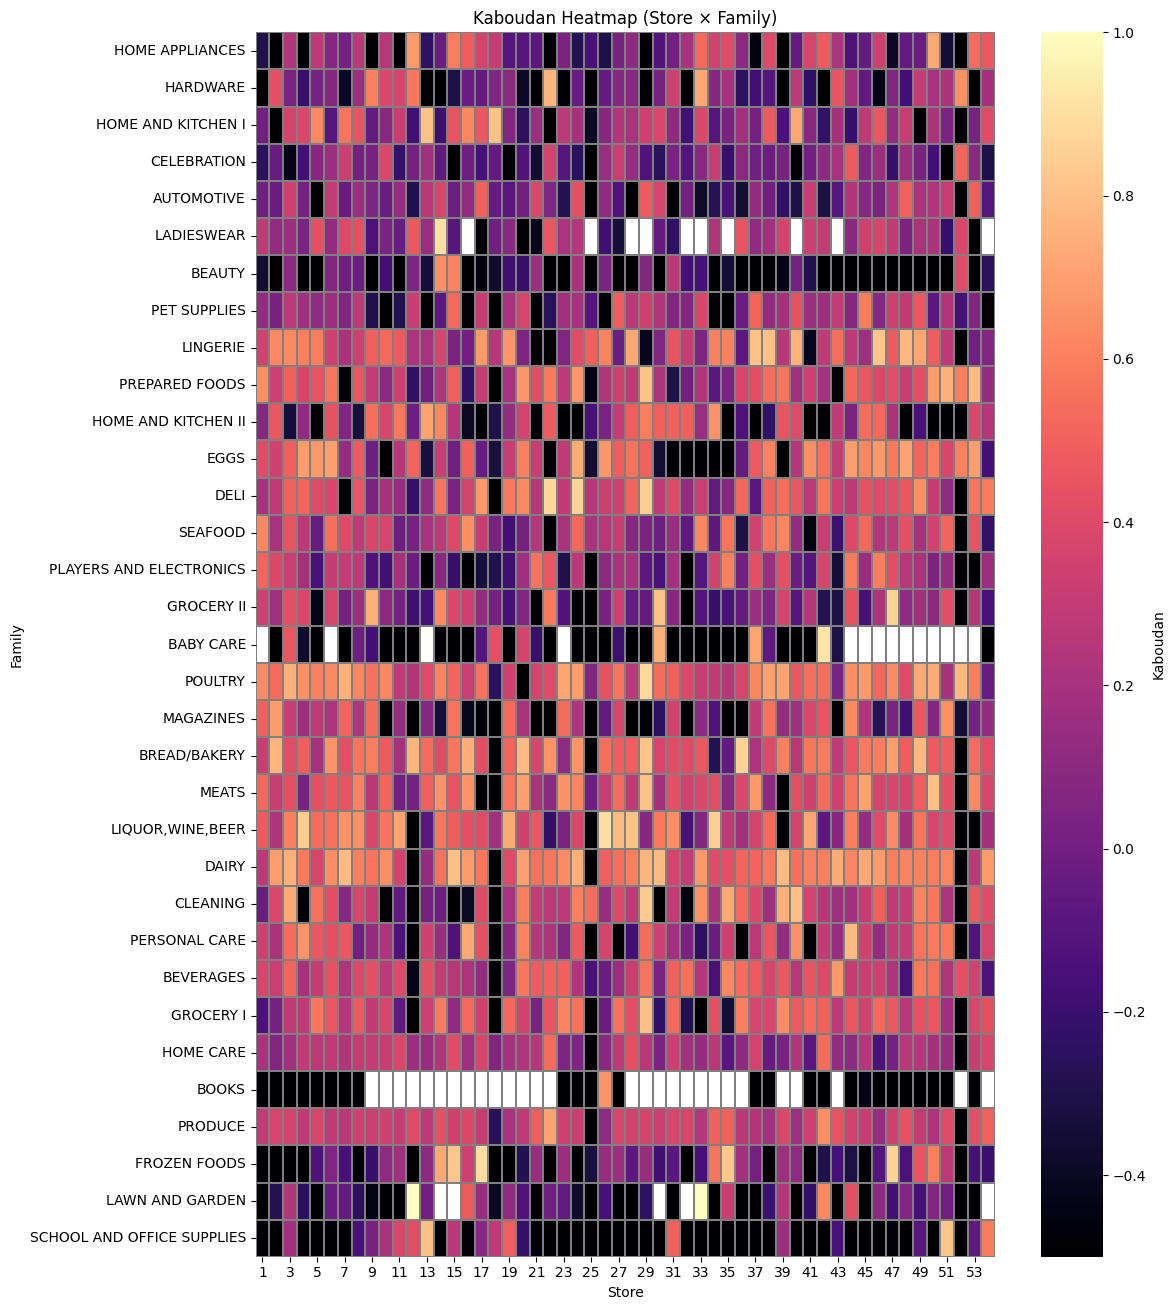

In [58]:
plot_forecastability_heatmap(
    forecastability_all,
    metric='Kaboudan',
    vmin=-0.5,
    vmax=1.0,
    cmap='magma'
)